### LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from decimal import getcontext
from sklearn.preprocessing import StandardScaler,RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder
import config as cnf 
import Utils as utils

c:\Users\HAMZA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### SETTINGS

In [2]:
# For output settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)

# For warnings
warnings.filterwarnings("ignore")

# For float point number
getcontext().prec = 5

### LOAD THE DATASETS

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### BASIC EXPLORATION

In [4]:
utils.check_df(train_df)

##################### Shape #####################
(8693, 14)
##################### Types #####################
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object
##################### Head #####################
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy        False
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0        9.0          25.0   549.0    44.0       Juanna Vines         True
2     0003_01     Europa    

In [5]:
utils.check_df(test_df)

##################### Shape #####################
(4277, 13)
##################### Types #####################
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object
##################### Head #####################
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False          0.0        0.0   

### EDITING COLUMN NAMES
To facilitate variable naming and reduce the risk of errors, we have standardized the format of variable names. The following transformations have been applied to achieve consistency and clarity:

1. All letters in variable names have been converted to uppercase to ensure uniformity and ease of recognition.

2. Spaces within variable names have been replaced with underscores ('_') to eliminate any whitespace-related issues and enhance readability.

3. The index variable has been removed from the dataset, as it serves no analytical purpose and has been excluded to streamline the data structure.

These naming conventions and data preprocessing steps aim to create a cleaner and more manageable dataset, reducing the likelihood of naming-related errors and enhancing the overall data quality and usability.

In [6]:
utils.first_edit(train_df)
utils.first_edit(test_df)

### VARIABLE SPLITTING 

I have performed data transformation by splitting the original variables "NAME", "PASSENGERID" and "CABIN" into multiple new variables, aiming to extract more granular information and improve the richness of our dataset.

1. From the "NAME" variable, I derived two new variables: "NAME" and "SURNAME". The "NAME" variable now contains the passengers' first names, while the "SURNAME" variable contains their last names. This separation allows us to address passengers more precisely and may reveal cultural or family-related patterns.

2. The "PASSENGERID" variable has been split into two new variables: "PASS1" and "PASS2." These variables provide a different representation of passenger identification, potentially offering insights into the organization or structure of passenger data.

3. The "CABIN" variable has been divided into three new variables: "DECK", "NUM" and "SIDE". "DECK" represents the deck or floor where the cabin is located, "NUM" denotes the cabin number, and "SIDE" indicates the side of the ship where the cabin is situated. These distinctions provide a more detailed understanding of passengers' cabin assignments.

By introducing these new variables, we aim to enrich our dataset and enhance our analytical capabilities, potentially leading to more meaningful and precise insights during data analysis and modeling.

In [7]:
train_df[['FNAME', 'SURNAME']] = train_df.NAME.str.split(" ", expand=True) 
test_df[['FNAME', 'SURNAME']] = test_df.NAME.str.split(" ", expand=True) 

train_df[['PASS1', 'PASS2']] = train_df.PASSENGERID.str.split("_", expand=True) 
test_df[['PASS1', 'PASS2']] = test_df.PASSENGERID.str.split("_", expand=True) 
    

train_df[['DECK', 'NUM','SIDE']] = train_df.CABIN.str.split("/", expand=True) 
test_df[['DECK', 'NUM','SIDE']] = test_df.CABIN.str.split("/", expand=True) 


In [8]:
# TRAIN
train_df.drop("NAME",axis=1,inplace=True)
train_df.drop("CABIN", axis=1, inplace=True)
train_df.drop("PASSENGERID", axis=1, inplace=True)

# TEST
test_df.drop("NAME",axis=1,inplace=True)
test_df.drop("CABIN", axis=1, inplace=True)
test_df.drop("PASSENGERID", axis=1, inplace=True)

### NA VALUES ANALYSIS 

#### TRAIN

In [9]:
na_cols = utils.missing_values_table(train_df,na_name=True)

              n_miss  ratio
CRYOSLEEP        217   2.50
SHOPPINGMALL     208   2.39
VIP              203   2.34
HOMEPLANET       201   2.31
FNAME            200   2.30
SURNAME          200   2.30
DECK             199   2.29
NUM              199   2.29
SIDE             199   2.29
VRDECK           188   2.16
FOODCOURT        183   2.11
SPA              183   2.11
DESTINATION      182   2.09
ROOMSERVICE      181   2.08
AGE              179   2.06


In [10]:
indices = []
for col in na_cols:
    indices.extend(train_df[train_df[col].isna()].index)
print(f"\nSum of NA {len(set(indices))}")


Sum of NA 2087


#### TEST

In [11]:
tstna_cols = utils.missing_values_table(test_df,na_name=True)

              n_miss  ratio
FOODCOURT        106   2.48
SPA              101   2.36
DECK             100   2.34
NUM              100   2.34
SIDE             100   2.34
SHOPPINGMALL      98   2.29
FNAME             94   2.20
SURNAME           94   2.20
CRYOSLEEP         93   2.17
VIP               93   2.17
DESTINATION       92   2.15
AGE               91   2.13
HOMEPLANET        87   2.03
ROOMSERVICE       82   1.92
VRDECK            80   1.87


In [12]:
indices = []
for col in tstna_cols:
    indices.extend(test_df[test_df[col].isna()].index)
print(f"\nSum of NA {len(set(indices))}")


Sum of NA 996


#### ZERO AGE

#### TRAIN

In [13]:
print(f"zero age {(train_df['AGE'] == 0).sum()}")
zero_age_death_count = train_df.loc[train_df['AGE'] == 0, cnf.target].sum()
print(f"\nNumber of not transported person aged 0: {zero_age_death_count}")

zero age 178

Number of not transported person aged 0: 144


#### TEST

In [14]:
print(f"zero age {(test_df['AGE'] == 0).sum()}")

zero age 82


We have observed that NA values are present in both the train and test datasets in similar proportions. The fact that NULL values were not modified is because it was considered that having similar numbers of NA values in the training and test sets had a meaningful impact.

### OBTAINING CATEGORICAL and NUMERICAL VARIABLES

In [15]:
cat_cols, num_cols = utils.grab_col_names(train_df)
test_cat_cols, test_num_cols = utils.grab_col_names(test_df)

### OUTLIER VALUES ANALYSIS

In [16]:
indices = []
for col in num_cols:
    indices.extend(utils.grab_outliers(train_df, col, index=True))
    print(col, len(indices))

indices = list(set(indices))
print(f"Total Outlier For train_df : {len(indices)}")

Empty DataFrame
Columns: [HOMEPLANET, CRYOSLEEP, DESTINATION, AGE, VIP, ROOMSERVICE, FOODCOURT, SHOPPINGMALL, SPA, VRDECK, TRANSPORTED, FNAME, SURNAME, PASS1, PASS2, DECK, NUM, SIDE]
Index: []
AGE 0
     HOMEPLANET CRYOSLEEP  DESTINATION   AGE    VIP  ROOMSERVICE  FOODCOURT  SHOPPINGMALL     SPA  VRDECK  TRANSPORTED    FNAME     SURNAME PASS1 PASS2 DECK  NUM SIDE
928      Europa     False  55 Cancri e  35.0   True       8030.0      300.0           0.0     0.0  1436.0        False    Naosa   Herpumble  0992    04  NaN  NaN  NaN
1177     Europa     False  TRAPPIST-1e  32.0  False       8168.0       69.0          11.0   371.0     0.0        False     Geno    Oderient  1243    02    A    9    P
4416     Europa     False  TRAPPIST-1e  27.0  False      14327.0     1487.0           0.0     1.0     0.0        False     Tope  Dishocatal  4690    02  NaN  NaN  NaN
4762     Europa     False  TRAPPIST-1e  32.0  False       8151.0     2052.0        1919.0  7352.0   754.0        False   Batrix  Fuel

In [17]:
index = []
for col in test_num_cols:
    index.extend(utils.grab_outliers(test_df, col, index=True))
    print(col, len(index))

index = list(set(index))
print(f"Total Outlier For test_df : {len(index)}")

Empty DataFrame
Columns: [HOMEPLANET, CRYOSLEEP, DESTINATION, AGE, VIP, ROOMSERVICE, FOODCOURT, SHOPPINGMALL, SPA, VRDECK, FNAME, SURNAME, PASS1, PASS2, DECK, NUM, SIDE]
Index: []
AGE 0
     HOMEPLANET CRYOSLEEP  DESTINATION   AGE    VIP  ROOMSERVICE  FOODCOURT  SHOPPINGMALL     SPA  VRDECK   FNAME   SURNAME PASS1 PASS2 DECK   NUM SIDE
1237     Europa     False  55 Cancri e  27.0  False      11567.0      246.0           0.0  5957.0   496.0  Alsuud  Suarging  2621    01    C    94    S
2741       Mars     False  TRAPPIST-1e  69.0  False       7407.0        0.0           0.0     0.0     0.0  Sceros     Karte  6051    01    F  1150    S
ROOMSERVICE 2
     HOMEPLANET CRYOSLEEP  DESTINATION   AGE    VIP  ROOMSERVICE  FOODCOURT  SHOPPINGMALL     SPA  VRDECK    FNAME   SURNAME PASS1 PASS2 DECK  NUM SIDE
101      Europa     False  55 Cancri e  39.0    NaN          0.0    25273.0           0.0    13.0  1714.0   Zedark  Asharing  0228    02    B    4    S
1561     Europa     False  TRAPPIST-1e  

We obtained similar results in our outlier detection for the NA values. Nevertheless, we will remove the 1% of outliers in the training set

In [18]:
train_df.drop(indices,axis=0,inplace=True)

### DATA VISUALIZE and PIVOT TABLE

#### TRANSPORTED

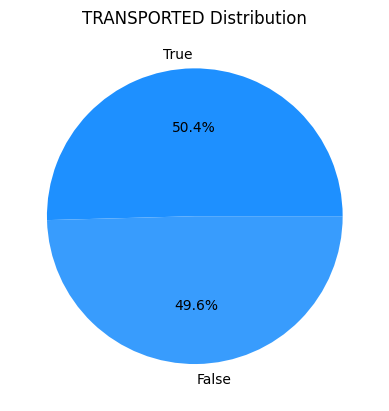

In [19]:
utils.plot_distributions(train_df,cnf.target, target_pie=True)

#### NUMERIC VARIABLES

The distribution of numeric variables, except for the 'Age' variable, was visualized by applying a logarithmic transformation due to its imbalance.

count    8470.000000
mean       28.793388
std        14.484524
min         0.000000
5%          4.000000
10%        13.000000
20%        18.000000
30%        21.000000
40%        24.000000
50%        27.000000
60%        30.000000
70%        35.000000
80%        41.000000
90%        49.000000
95%        56.000000
99%        65.000000
max        79.000000
Name: AGE, dtype: float64


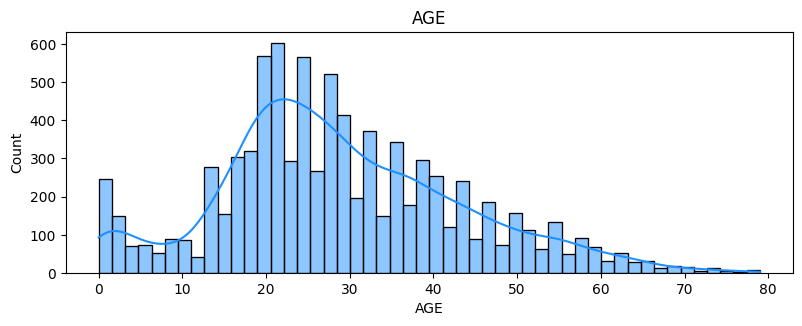

In [20]:
utils.plot_distributions(train_df, num_cols[:1], kde=True, log_transform=False)

count    8470.000000
mean      215.432349
std       598.522897
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         8.000000
80%       173.000000
90%       750.000000
95%      1257.100000
99%      2990.790000
max      7406.000000
Name: ROOMSERVICE, dtype: float64


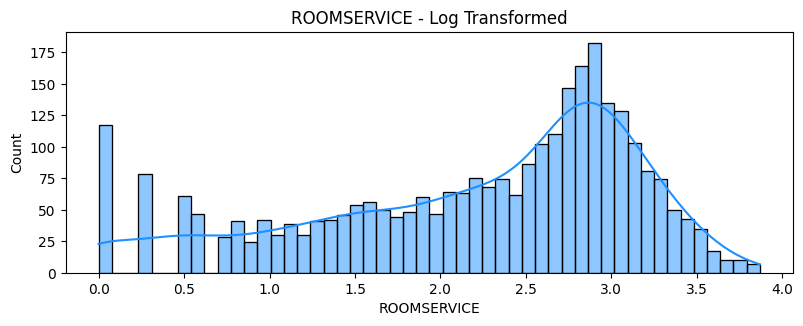

count     8467.000000
mean       435.126964
std       1460.928314
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%         11.000000
80%        243.800000
90%        996.400000
95%       2662.200000
99%       7708.840000
max      18481.000000
Name: FOODCOURT, dtype: float64


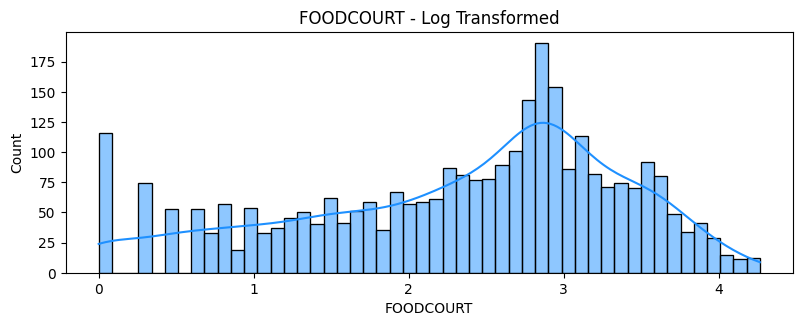

count    8441.000000
mean      159.106030
std       451.403222
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         5.000000
80%        95.000000
90%       615.000000
95%       909.000000
99%      2182.000000
max      5635.000000
Name: SHOPPINGMALL, dtype: float64


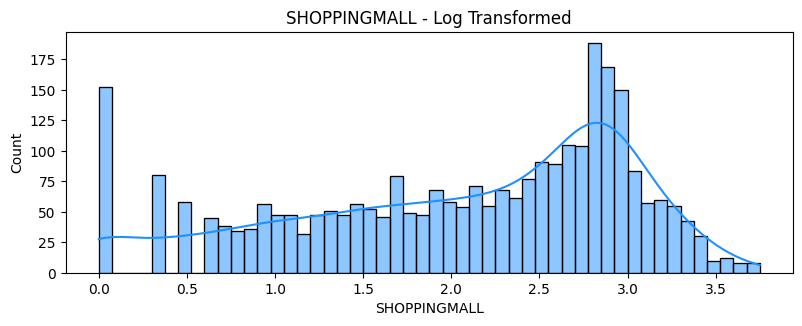

count     8467.000000
mean       288.754813
std        984.481645
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%         13.000000
80%        173.800000
90%        723.400000
95%       1547.100000
99%       5002.460000
max      13208.000000
Name: SPA, dtype: float64


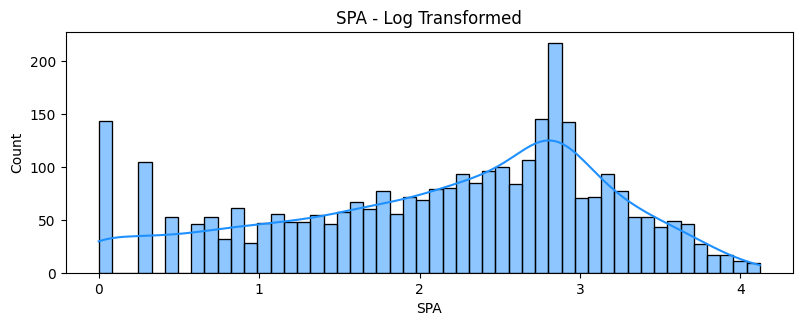

count     8461.000000
mean       288.981090
std       1030.957337
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          8.000000
80%        147.000000
90%        722.000000
95%       1479.000000
99%       5484.600000
max      12708.000000
Name: VRDECK, dtype: float64


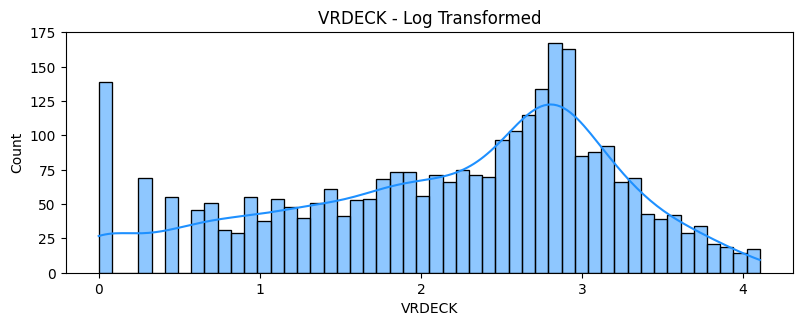

In [21]:
utils.plot_distributions(train_df, num_cols[1:], kde=True, log_transform=True, alert=False)

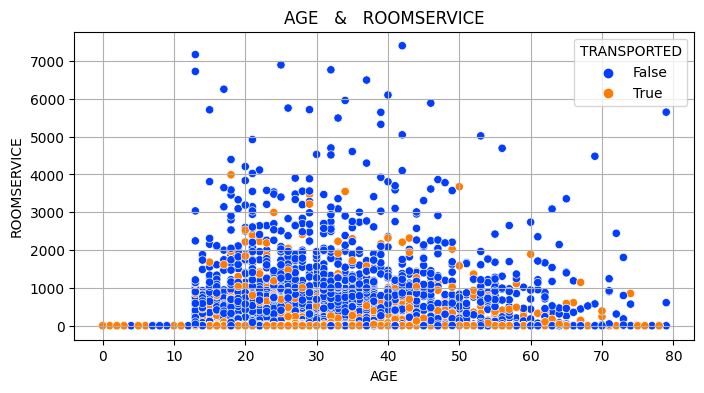

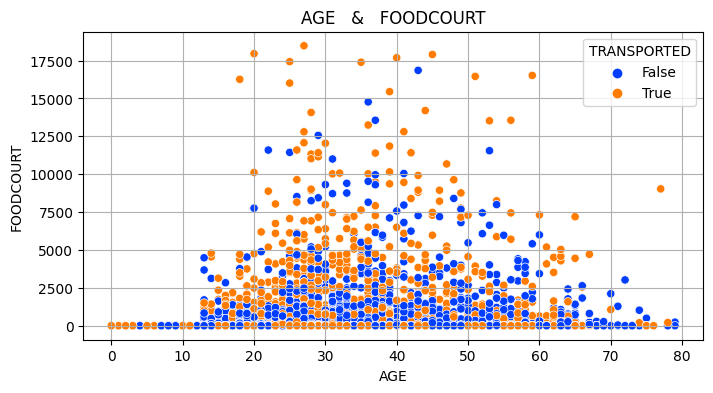

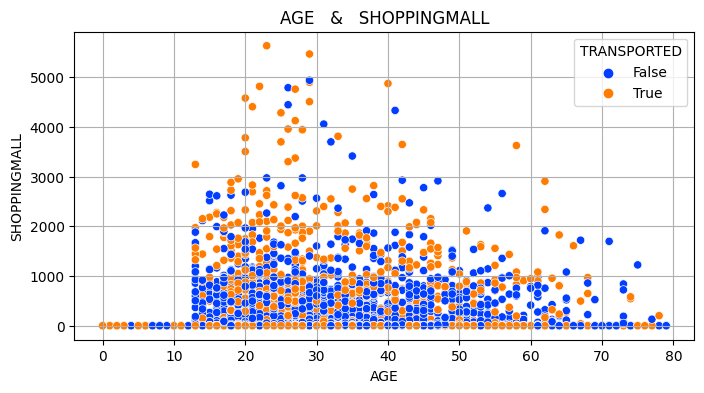

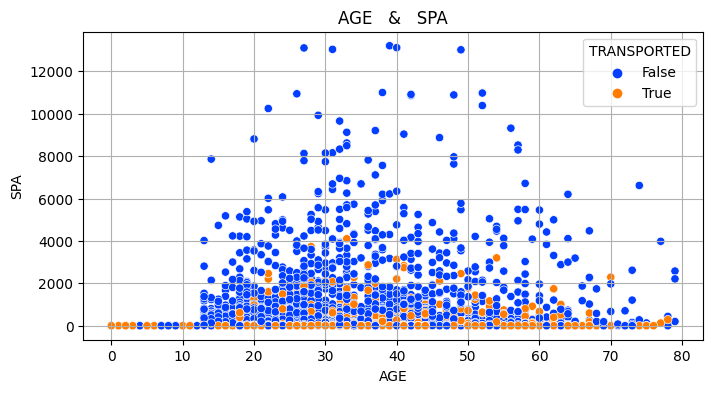

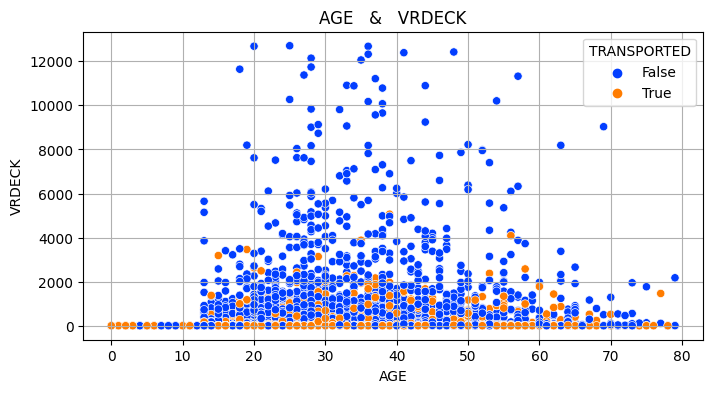

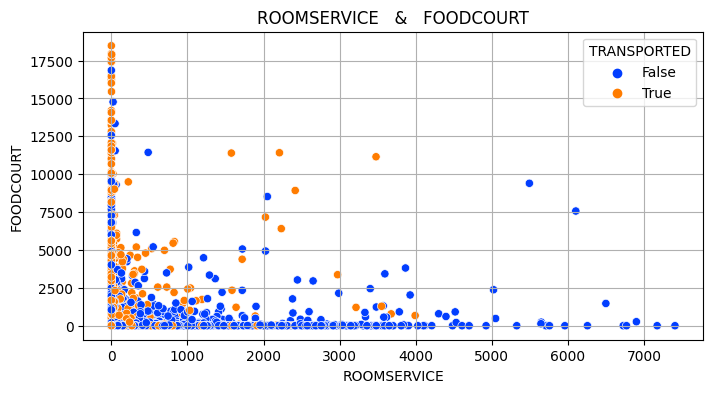

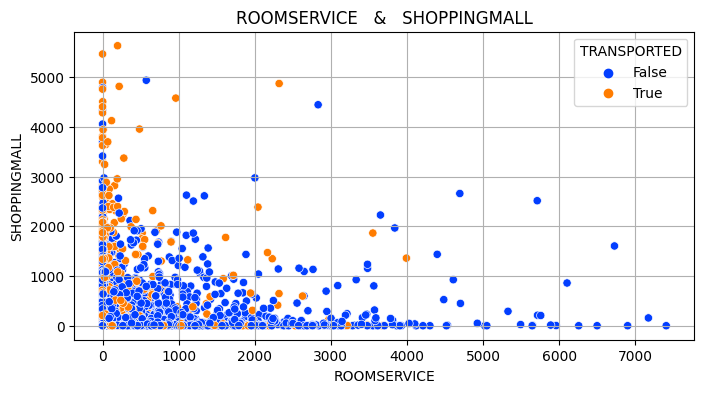

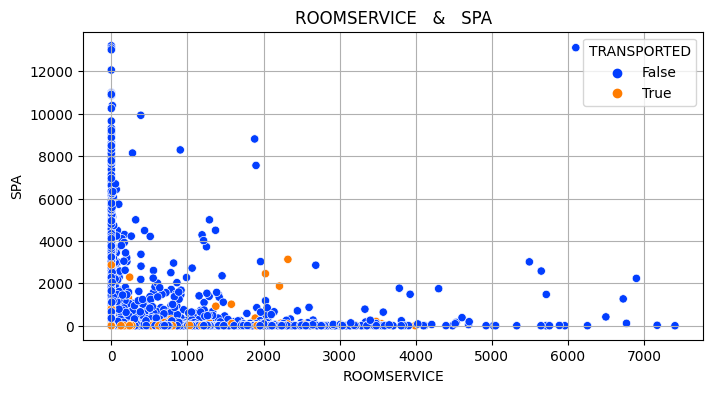

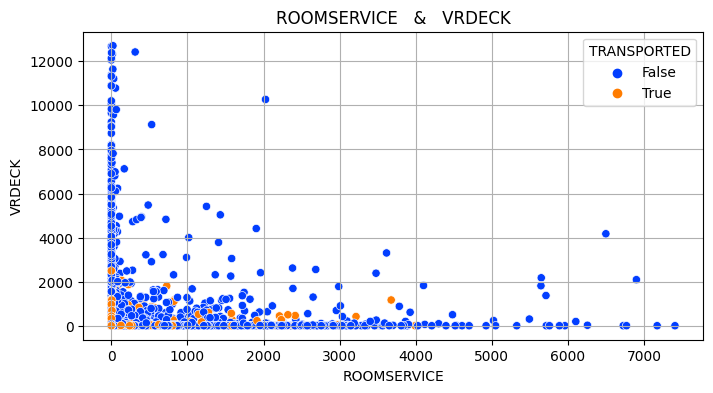

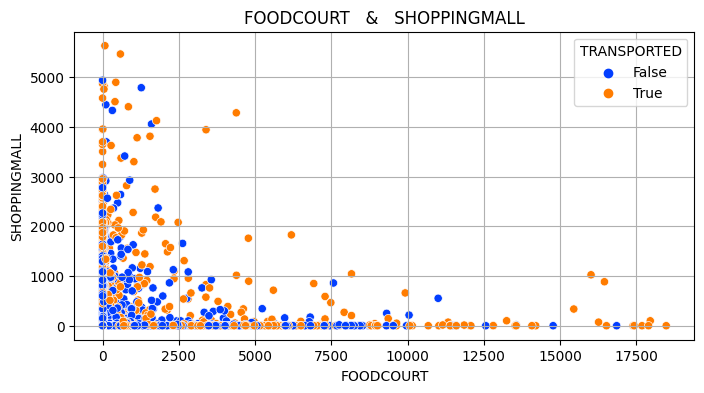

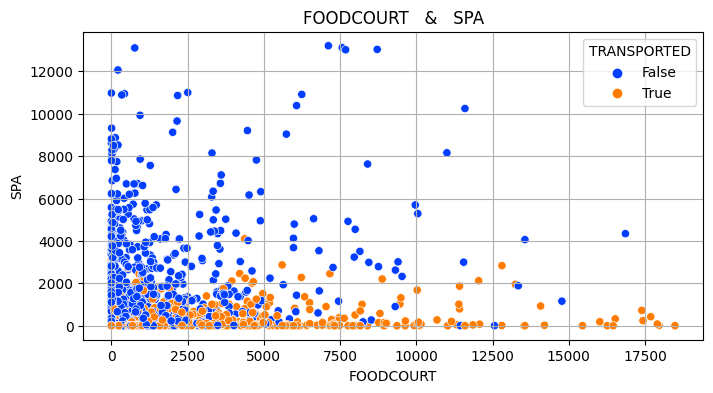

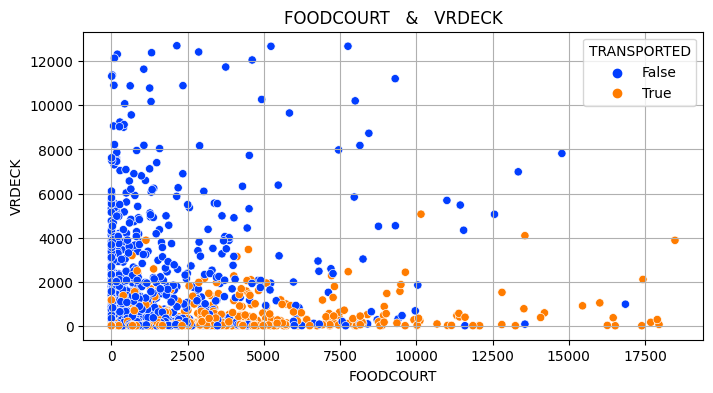

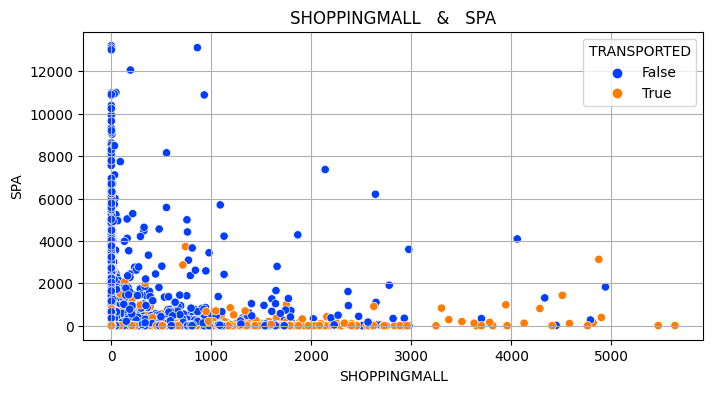

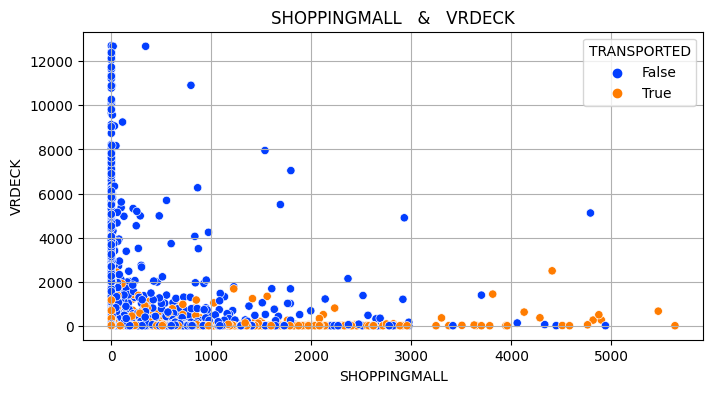

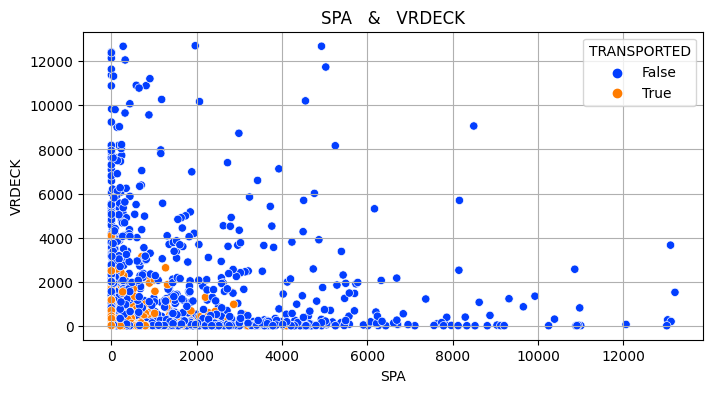

In [22]:
utils.numcols_target_corr(train_df, num_cols)

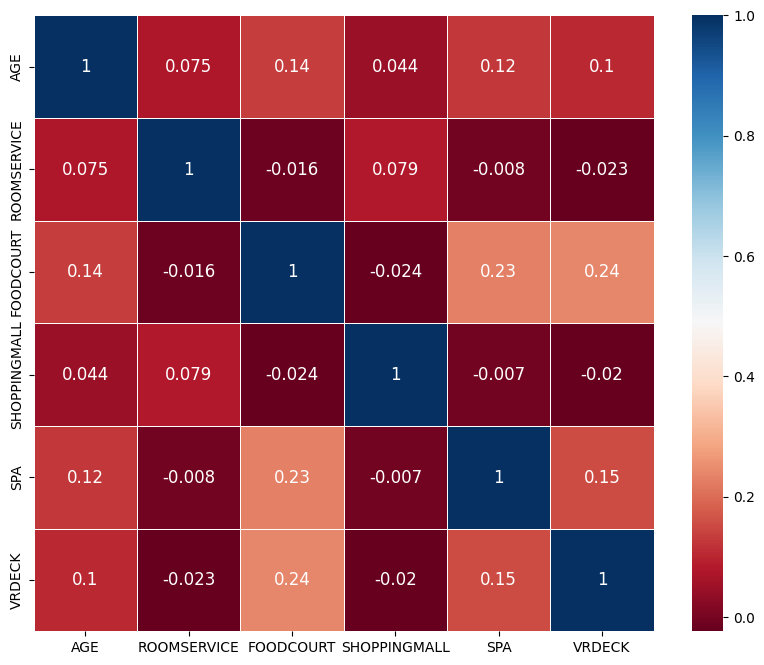

In [23]:
utils.correlation_matrix(train_df,num_cols)

            HOMEPLANET      Ratio
HOMEPLANET                       
Earth             4602  53.208463
Europa            2092  24.187767
Mars              1755  20.291363
##########################################
NA in HOMEPLANET : 200
##########################################


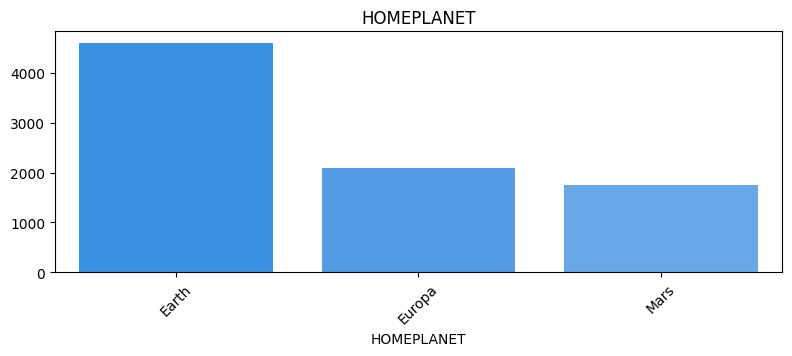

           CRYOSLEEP      Ratio
CRYOSLEEP                      
False           5396  62.388715
True            3037  35.113886
##########################################
NA in CRYOSLEEP : 216
##########################################


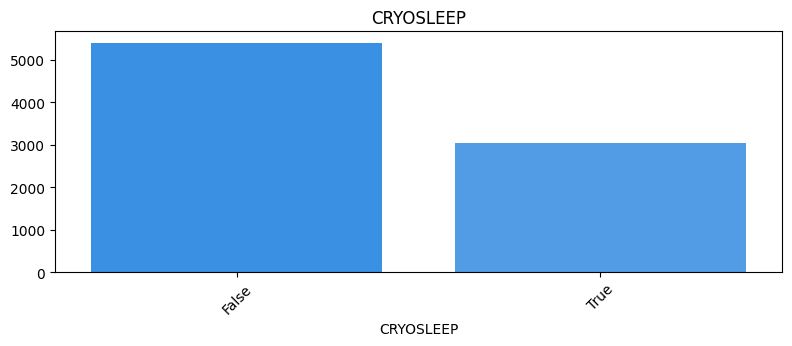

               DESTINATION      Ratio
DESTINATION                          
TRAPPIST-1e           5894  68.146607
55 Cancri e           1779  20.568852
PSO J318.5-22          795   9.191814
##########################################
NA in DESTINATION : 181
##########################################


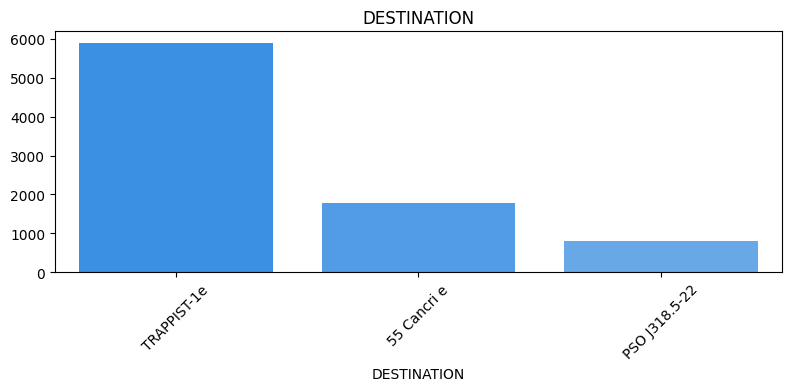

        VIP      Ratio
VIP                   
False  8253  95.421436
True    194   2.243034
##########################################
NA in VIP : 202
##########################################


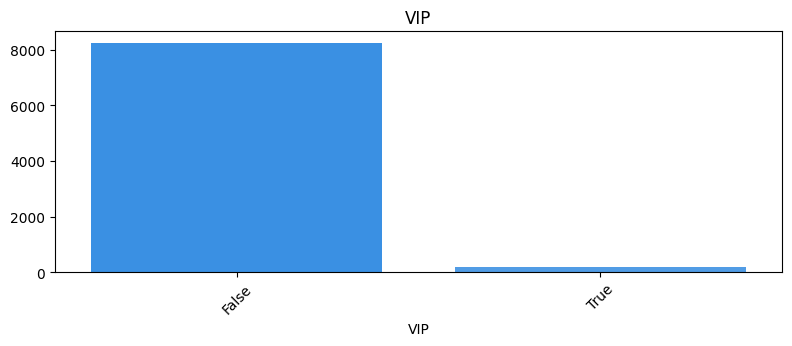

       PASS2      Ratio
PASS2                  
01      6188  71.545843
02      1401  16.198404
03       570   6.590357
04       230   2.659267
05       126   1.456816
06        75   0.867152
07        46   0.531853
08        13   0.150306
##########################################
NA in PASS2 : 0
##########################################


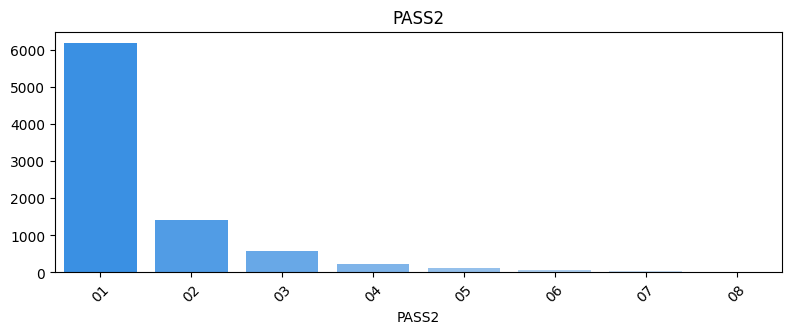

      DECK      Ratio
DECK                 
F     2791  32.269627
G     2559  29.587236
E      871  10.070528
B      761   8.798705
C      734   8.486530
D      477   5.515088
A      254   2.936756
T        5   0.057810
##########################################
NA in DECK : 197
##########################################


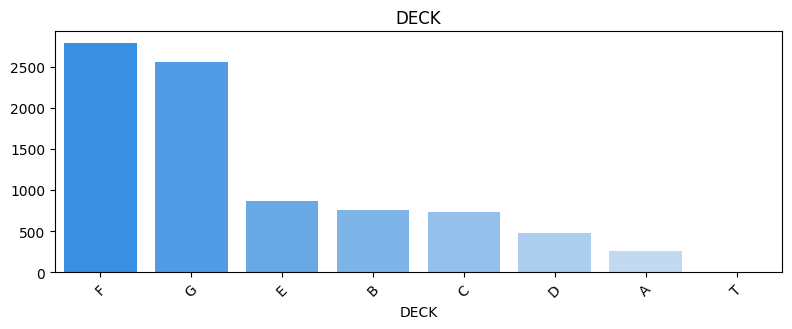

      SIDE      Ratio
SIDE                 
S     4271  49.381431
P     4181  48.340849
##########################################
NA in SIDE : 197
##########################################


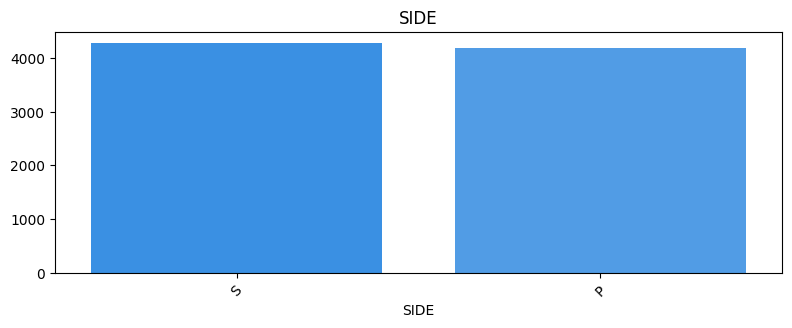

             TRANSPORTED      Ratio
TRANSPORTED                        
True                4361  50.422014
False               4288  49.577986
##########################################
NA in TRANSPORTED : 0
##########################################


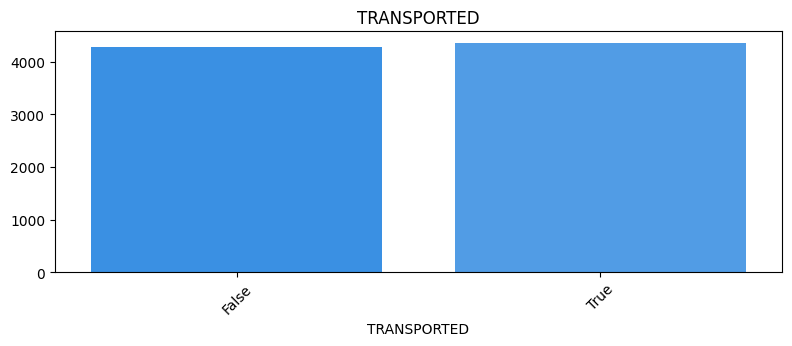

In [24]:
utils.plot_distributions(train_df, cat_cols, label_angle=45, order_cats=True)

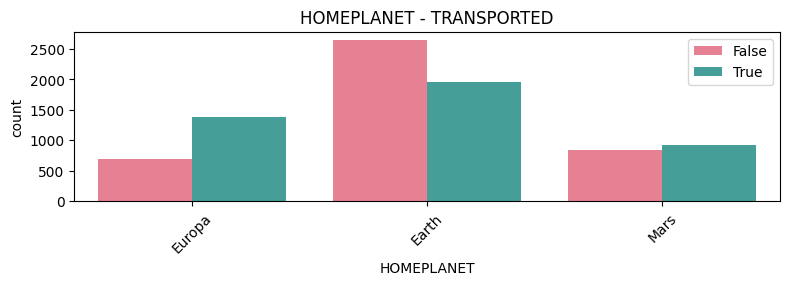

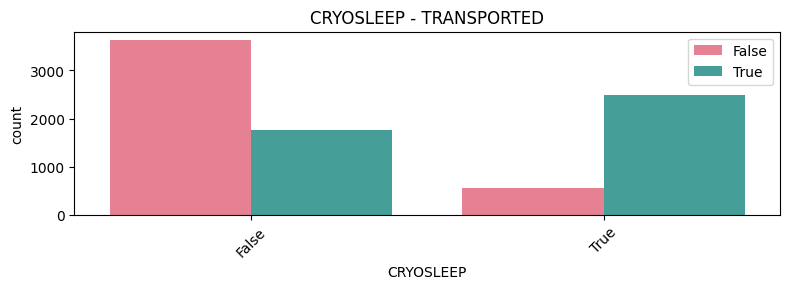

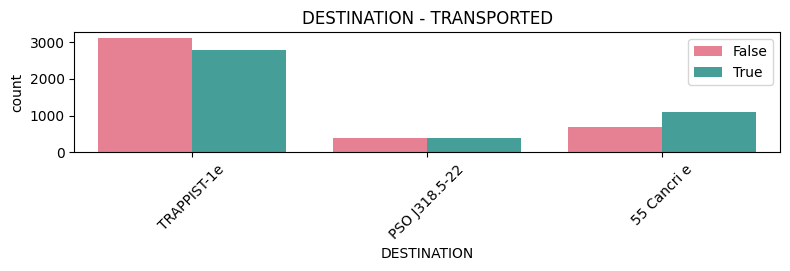

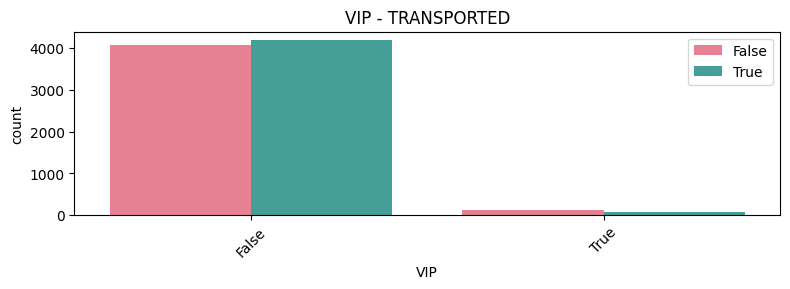

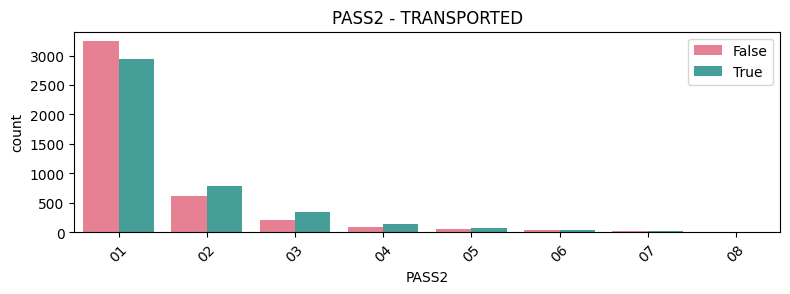

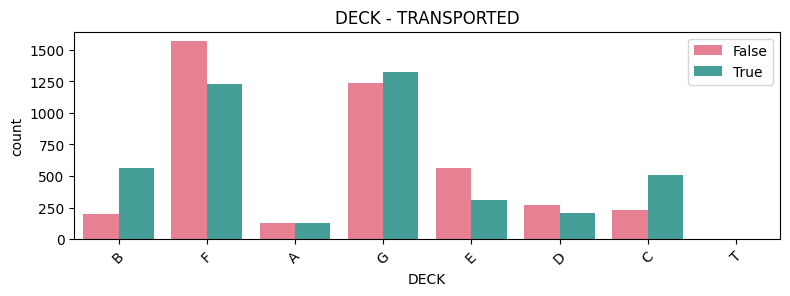

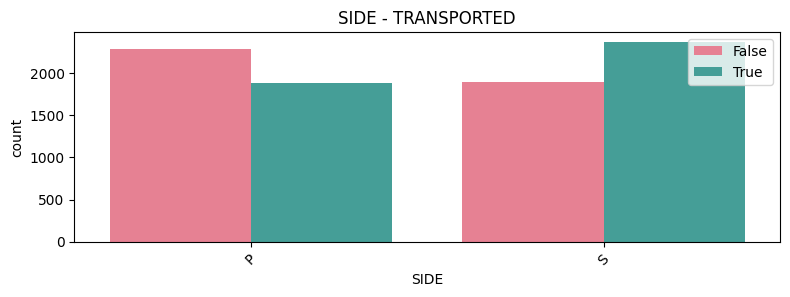

In [25]:
for col in cat_cols:
    if col != cnf.target:
        utils.plot_categorical_data(train_df, col, cnf.target, f"{col} - TRANSPORTED", label_angle=45)

#### Pivot Tables

In [26]:
train_df.pivot_table(columns=['HOMEPLANET', 'DESTINATION', 'VIP'], values=cnf.target, fill_value='NONE').T.round(2)

TRANSPORTED
HOMEPLANET DESTINATION   VIP               
Earth      55 Cancri e   False         0.51
           PSO J318.5-22 False         0.50
           TRAPPIST-1e   False         0.39
Europa     55 Cancri e   False         0.72
                         True          0.39
           PSO J318.5-22 False         1.00
                         True          0.56
           TRAPPIST-1e   False         0.64
                         True          0.61
Mars       55 Cancri e   False         0.61
           PSO J318.5-22 False         0.46
                         True          0.25
           TRAPPIST-1e   False         0.52
                         True          0.15

In [27]:
train_df.pivot_table(columns=['HOMEPLANET', 'DESTINATION', 'CRYOSLEEP'], values=cnf.target, fill_value='NONE').T.round(2)

TRANSPORTED
HOMEPLANET DESTINATION   CRYOSLEEP             
Earth      55 Cancri e   False             0.39
                         True              0.77
           PSO J318.5-22 False             0.32
                         True              0.67
           TRAPPIST-1e   False             0.31
                         True              0.62
Europa     55 Cancri e   False             0.37
                         True              1.00
           PSO J318.5-22 False             0.56
                         True              1.00
           TRAPPIST-1e   False             0.42
                         True              0.98
Mars       55 Cancri e   False             0.37
                         True              0.97
           PSO J318.5-22 False             0.33
                         True              0.91
           TRAPPIST-1e   False             0.26
                         True              0.90

In [28]:
mean_age = train_df.groupby(['HOMEPLANET', 'DESTINATION', cnf.target])['AGE'].mean().reset_index()

mean_age.pivot_table(index=['HOMEPLANET', 'DESTINATION', cnf.target], values='AGE', fill_value='NONE').round(2)

AGE
HOMEPLANET DESTINATION   TRANSPORTED       
Earth      55 Cancri e   False        25.13
                         True         21.73
           PSO J318.5-22 False        28.88
                         True         24.58
           TRAPPIST-1e   False        27.67
                         True         24.62
Europa     55 Cancri e   False        36.85
                         True         33.04
           PSO J318.5-22 False        41.75
                         True         35.14
           TRAPPIST-1e   False        36.15
                         True         33.48
Mars       55 Cancri e   False        29.81
                         True         25.53
           PSO J318.5-22 False        35.67
                         True         37.81
           TRAPPIST-1e   False        32.04
                         True         26.58

In [29]:
mean_age = train_df.groupby(['HOMEPLANET', 'DESTINATION', cnf.target])['ROOMSERVICE'].mean().reset_index()

mean_age.pivot_table(index=['HOMEPLANET', 'DESTINATION', cnf.target], values='ROOMSERVICE', fill_value='NONE').round(2)

ROOMSERVICE
HOMEPLANET DESTINATION   TRANSPORTED             
Earth      55 Cancri e   False             246.71
                         True               42.47
           PSO J318.5-22 False             101.52
                         True               40.50
           TRAPPIST-1e   False             202.66
                         True               64.80
Europa     55 Cancri e   False             337.10
                         True               24.02
           PSO J318.5-22 False               1.00
                         True                5.07
           TRAPPIST-1e   False             215.46
                         True               52.47
Mars       55 Cancri e   False            1140.17
                         True              163.56
           PSO J318.5-22 False             412.12
                         True              317.33
           TRAPPIST-1e   False            1033.90
                         True               97.95

In [30]:
mean_age = train_df.groupby(['HOMEPLANET', cnf.target])['ROOMSERVICE'].mean().reset_index()

mean_age.pivot_table(index=['HOMEPLANET', cnf.target], values='ROOMSERVICE', fill_value='NONE').round(2)

ROOMSERVICE
HOMEPLANET TRANSPORTED             
Earth      False             196.49
           True               56.37
Europa     False             256.99
           True               38.76
Mars       False            1021.98
           True              110.48

### FEATURE EXTRACTION

#### NEW_CAT_AGE 
negative affect

In [31]:
# train_df.loc[(train_df['AGE'] < 20), "NEW_CAT_AGE"] = 'CHILD'
# train_df.loc[(train_df['AGE'] >= 20) & (train_df['AGE'] <= 40), "NEW_CAT_AGE"] = 'ADULT'
# train_df.loc[(train_df['AGE'] >= 40) & (train_df['AGE'] <= 60), "NEW_CAT_AGE"] = 'NORMAL_AGE'
# train_df.loc[(train_df['AGE'] > 60 ), "NEW_CAT_AGE"] = 'OLD'

In [32]:
# test_df.loc[(test_df['AGE'] < 20), "NEW_CAT_AGE"] = 'CHILD'
# test_df.loc[(test_df['AGE'] >= 20) & (test_df['AGE'] <= 40), "NEW_CAT_AGE"] = 'ADULT'
# test_df.loc[(test_df['AGE'] >= 40) & (test_df['AGE'] <= 60), "NEW_CAT_AGE"] = 'NORMAL_AGE'
# test_df.loc[(test_df['AGE'] > 60 ), "NEW_CAT_AGE"] = 'OLD'

#### NEW_CAT_SHOPPING
negative affect

In [33]:
# train_df.loc[(train_df['SHOPPINGMALL'] == 0 ), "NEW_CAT_SHOPPING"] = 'POOR'
# train_df.loc[(train_df['SHOPPINGMALL'] > 0 ), "NEW_CAT_SHOPPING"] = 'RICH'
# test_df.loc[(test_df['SHOPPINGMALL'] == 0 ), "NEW_CAT_SHOPPING"] = 'POOR'
# test_df.loc[(test_df['SHOPPINGMALL'] > 0 ), "NEW_CAT_SHOPPING"] = 'RICH'

#### NEW_CAT_FOOD
negative affect

In [34]:
# train_df.loc[(train_df['FOODCOURT'] == 0 ), "NEW_CAT_FOOD"] = 'HUNGRY'
# train_df.loc[(train_df['FOODCOURT'] > 0 ), "NEW_CAT_FOOD"] = 'FULL'
# test_df.loc[(test_df['FOODCOURT'] == 0 ), "NEW_CAT_FOOD"] = 'HUNGRY'
# test_df.loc[(test_df['FOODCOURT'] > 0 ), "NEW_CAT_FOOD"] = 'FULL'

#### NEW_CAT_ROOM
negative affect

In [35]:
# train_df.loc[(train_df['ROOMSERVICE'] == 0 ), "NEW_CAT_ROOM"] = 'SHED'
# train_df.loc[(train_df['ROOMSERVICE'] > 0 ), "NEW_CAT_ROOM"] = 'LUX'
# test_df.loc[(test_df['ROOMSERVICE'] == 0 ), "NEW_CAT_ROOM"] = 'SHED'
# test_df.loc[(test_df['ROOMSERVICE'] > 0 ), "NEW_CAT_ROOM"] = 'LUX'

#### NEW_CAT_SPA
negative affect

In [36]:
# train_df.loc[(train_df['SPA'] == 0 ), "NEW_CAT_SPA"] = 'SICK'
# train_df.loc[(train_df['SPA'] > 0 ), "NEW_CAT_SPA"] = 'RELAX'
# test_df.loc[(test_df['SPA'] == 0 ), "NEW_CAT_SPA"] = 'RELAX'
# test_df.loc[(test_df['SPA'] > 0 ), "NEW_CAT_SPA"] = 'SICK'

#### NEW_CAT_VRDECK
negative affect

In [37]:
# train_df.loc[(train_df['VRDECK'] == 0 ), "NEW_CAT_VRDECK"] = 'DEAD'
# train_df.loc[(train_df['VRDECK'] > 0 ), "NEW_CAT_VRDECK"] = 'ALIVE'
# test_df.loc[(test_df['VRDECK'] == 0 ), "NEW_CAT_VRDECK"] = 'DEAD'
# test_df.loc[(test_df['VRDECK'] > 0 ), "NEW_CAT_VRDECK"] = 'ALIVE'

#### TOTALBILL
positive affect

In [38]:
train_df['TOTALBILL'] = train_df['VRDECK'] + train_df['SPA'] + train_df['ROOMSERVICE'] + train_df['FOODCOURT'] + train_df['SHOPPINGMALL']
test_df['TOTALBILL'] = train_df['VRDECK'] + train_df['SPA'] + train_df['ROOMSERVICE'] + train_df['FOODCOURT'] + train_df['SHOPPINGMALL']

#### NEW_CAT_FOODCOURT
positive affect

In [39]:
train_df.loc[(train_df['FOODCOURT'] < 15), "NEW_CAT_FOODCOURT"] = 'POOR_FOODCOURT'
test_df.loc[(test_df['FOODCOURT'] >= 15) & (test_df['FOODCOURT'] <= 2000), "NEW_CAT_FOODCOURT"] = 'GOOD_FOODCOURT'
test_df.loc[(test_df['FOODCOURT'] > 2000), "NEW_CAT_FOODCOURT"] = 'EXCELLENT_FOODCOURT'

test_df.loc[(test_df['FOODCOURT'] < 15), "NEW_CAT_FOODCOURT"] = 'POOR_FOODCOURT'
test_df.loc[(test_df['FOODCOURT'] >= 15) & (test_df['FOODCOURT'] <= 2000), "NEW_CAT_FOODCOURT"] = 'GOOD_FOODCOURT'
test_df.loc[(test_df['FOODCOURT'] > 2000), "NEW_CAT_FOODCOURT"] = 'EXCELLENT_FOODCOURT'

#### NEW_CAT_ROOMSERVICE
positive affect

In [40]:
train_df.loc[(train_df['ROOMSERVICE'] < 10), "NEW_CAT_ROOMSERVICE"] = 'POOR'
train_df.loc[(train_df['ROOMSERVICE'] >= 10) & (train_df['ROOMSERVICE'] <= 1250), "NEW_CAT_ROOMSERVICE"] = 'GOOD'
train_df.loc[(train_df['ROOMSERVICE'] > 1250), "NEW_CAT_ROOMSERVICE"] = 'EXCELLENT'
    
test_df.loc[(test_df['ROOMSERVICE'] < 10), "NEW_CAT_ROOMSERVICE"] = 'POOR'
test_df.loc[(test_df['ROOMSERVICE'] >= 10) & (test_df['ROOMSERVICE'] <= 1250), "NEW_CAT_ROOMSERVICE"] = 'GOOD'
test_df.loc[(test_df['ROOMSERVICE'] > 1250), "NEW_CAT_ROOMSERVICE"] = 'EXCELLENT'

In [41]:
cat_cols, num_cols = utils.grab_col_names(train_df)
test_cat_cols, test_num_cols = utils.grab_col_names(test_df)

We have transformed the operations we performed into functions to ensure reusability and minimize code repetition. The following 'data_prep' function has been written for this purpose.

In [42]:
def dataprep(dataframe,outlier=1):
    dataframe = dataframe.fillna(np.nan)
    
    # EDITS
    utils.first_edit(dataframe)
    
    # ------------SPLIT------------
    # PASSENGERID
    dataframe[['PASS1', 'PASS2']] = dataframe.PASSENGERID.str.split("_", expand=True) 
    
    # CABIN
    dataframe[['DECK', 'NUM','SIDE']] = dataframe.CABIN.str.split("/", expand=True) 
    
    # NAME
    dataframe[['FNAME', 'SURNAME']] = dataframe.NAME.str.split(" ", expand=True) 
    
    # NEW_CAT_FOODCOURT
    dataframe.loc[(dataframe['FOODCOURT'] < 15), "NEW_CAT_FOODCOURT"] = 'POOR_FOODCOURT'
    dataframe.loc[(dataframe['FOODCOURT'] >= 15) & (dataframe['FOODCOURT'] <= 2000), "NEW_CAT_FOODCOURT"] = 'GOOD_FOODCOURT'
    dataframe.loc[(dataframe['FOODCOURT'] > 2000), "NEW_CAT_FOODCOURT"] = 'EXCELLENT_FOODCOURT'
    
    # NEW_CAT_ROOMSERVICE
    dataframe.loc[(dataframe['ROOMSERVICE'] < 10), "NEW_CAT_ROOMSERVICE"] = 'POOR'
    dataframe.loc[(dataframe['ROOMSERVICE'] >= 10) & (dataframe['ROOMSERVICE'] <= 1250), "NEW_CAT_ROOMSERVICE"] = 'GOOD'
    dataframe.loc[(dataframe['ROOMSERVICE'] > 1250), "NEW_CAT_ROOMSERVICE"] = 'EXCELLENT'
    
    # DROP
    dataframe.drop("CABIN", axis=1, inplace=True)
    dataframe.drop("PASSENGERID", axis=1, inplace=True)
    dataframe.drop("NAME", axis=1, inplace=True)
    
    cat_cols, num_cols = utils.grab_col_names(dataframe)
    
    # OUTLIER
    if outlier:

        indices = []
        for col in num_cols:
            indices.extend(utils.grab_outliers(dataframe, col, index=True))
            print(col, len(indices))
        indices = list(set(indices))
        print(f"Total Outlier For train_df : {len(indices)}")
        dataframe.drop(indices,axis=0,inplace=True)
        
        dataframe.TRANSPORTED = dataframe.TRANSPORTED.replace({True: 1, False:0})
        i = cat_cols.index("TRANSPORTED")
        cat_cols.pop(i)
    
    
    # ENCODER
    ordinal = ['FNAME', 'SURNAME'] 
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    dataframe[ordinal + cat_cols] = ordinal_encoder.fit_transform(dataframe[ordinal + cat_cols]) 
    
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
    
    return cat_cols, num_cols,dataframe

In [43]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [44]:
cat_cols, num_cols,train_df = dataprep(train_df)
test_cat_cols, test_num_cols, test_df = dataprep(test_df,outlier=0)

Empty DataFrame
Columns: [HOMEPLANET, CRYOSLEEP, DESTINATION, AGE, VIP, ROOMSERVICE, FOODCOURT, SHOPPINGMALL, SPA, VRDECK, TRANSPORTED, PASS1, PASS2, DECK, NUM, SIDE, FNAME, SURNAME, NEW_CAT_FOODCOURT, NEW_CAT_ROOMSERVICE]
Index: []
AGE 0
     HOMEPLANET CRYOSLEEP  DESTINATION   AGE    VIP  ROOMSERVICE  FOODCOURT  SHOPPINGMALL     SPA  VRDECK  TRANSPORTED PASS1 PASS2 DECK   NUM  SIDE    FNAME     SURNAME    NEW_CAT_FOODCOURT NEW_CAT_ROOMSERVICE
928      Europa     False  55 Cancri e  35.0   True       8030.0      300.0           0.0     0.0  1436.0        False  0992    04  NaN  None  None    Naosa   Herpumble       GOOD_FOODCOURT           EXCELLENT
1177     Europa     False  TRAPPIST-1e  32.0  False       8168.0       69.0          11.0   371.0     0.0        False  1243    02    A     9     P     Geno    Oderient       GOOD_FOODCOURT           EXCELLENT
4416     Europa     False  TRAPPIST-1e  27.0  False      14327.0     1487.0           0.0     1.0     0.0        False  4690    02 

### PRE-MODEL

In [45]:
train_df.head()

,AGE,ROOMSERVICE,FOODCOURT,SHOPPINGMALL,SPA,VRDECK,TRANSPORTED,PASS1,NUM,FNAME,SURNAME,HOMEPLANET_1.0,HOMEPLANET_2.0,CRYOSLEEP_1.0,DESTINATION_1.0,DESTINATION_2.0,VIP_1.0,PASS2_1.0,PASS2_2.0,PASS2_3.0,PASS2_4.0,PASS2_5.0,PASS2_6.0,PASS2_7.0,DECK_1.0,DECK_2.0,DECK_3.0,DECK_4.0,DECK_5.0,DECK_6.0,DECK_7.0,SIDE_1.0,SIDE_2.0,NEW_CAT_FOODCOURT_1.0,NEW_CAT_FOODCOURT_2.0,NEW_CAT_ROOMSERVICE_1.0,NEW_CAT_ROOMSERVICE_2.0
0,39.0,0.0,0.0,0.0,0.0,0.0,0,0001,0,1613.0,1427.0,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0002,0,1406.0,2104.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0003,0,156.0,1985.0,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0003,0,2274.0,1985.0,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0004,1,2639.0,1774.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False


### SCALING

In [46]:
y = train_df["TRANSPORTED"]
X = train_df.drop(["TRANSPORTED"], axis=1)

# SCALING
X_scaled = RobustScaler().fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)

In [47]:
X_scaled_test = RobustScaler().fit_transform(test_df)

X_test = pd.DataFrame(X_scaled_test, columns=test_df.columns)

### HYPERPARAMETRE OPTIMIZATION

In [48]:
best_model = utils.hyperparameter_optimization(X,y,scoring="accuracy")

Hyperparameter Optimization....
########## XGBoost ##########


accuracy (Before): 0.6531
accuracy (After): 0.6983
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'num_class': 8, 'objective': 'multi:softmax'}

########## LightGBM ##########
accuracy (Before): 0.7053
accuracy (After): 0.7467
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 400}



In [49]:
def sample_sub(ypred):
  sample = pd.read_csv("sample_submission.csv")

  submission = pd.DataFrame({"PassengerId": sample["PassengerId"],
                             "Transported": ypred})
  submission["Transported"] = submission["Transported"].astype(bool)                          
  submission.to_csv("thend.csv",index=False)

In [50]:
model = LGBMClassifier(colsample_bytree = 1, learning_rate =  0.01, n_estimators = 400).fit(X,y)
y_pred = model.predict(X_test)

sample_sub(y_pred)

[LightGBM] [Info] Number of positive: 4361, number of negative: 4288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2423
[LightGBM] [Info] Number of data points in the train set: 8649, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504220 -> initscore=0.016881
[LightGBM] [Info] Start training from score 0.016881


### FEATURE IMPORTANCE

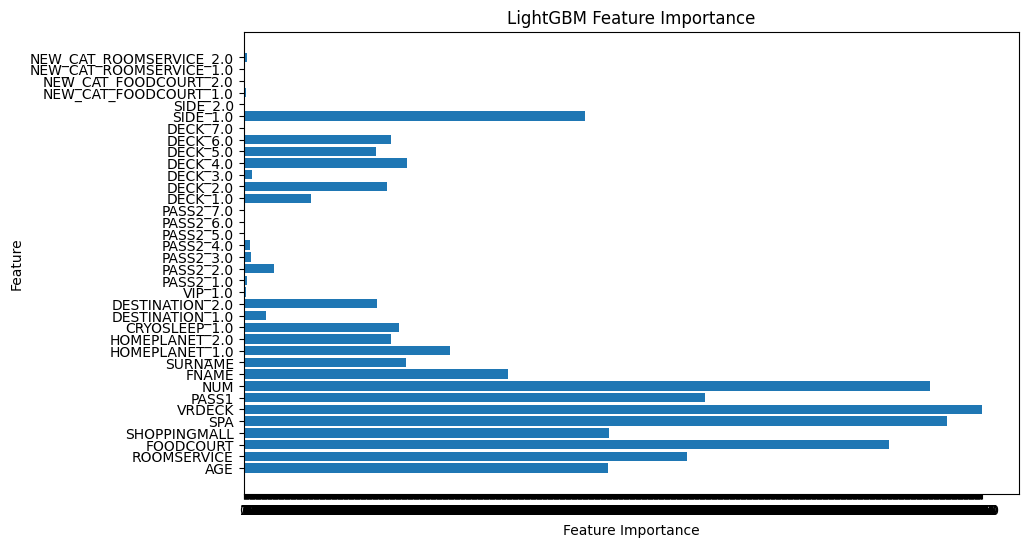

In [51]:
importance_values = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_values)), importance_values, align="center")
plt.yticks(range(len(importance_values)), feature_names)

# İşte eklediğimiz kısım:
plt.xticks(range(0, max(importance_values)+1))  # x ekseni işaretlerini ayarla

plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.show()